In [99]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import GRU
from keras import regularizers
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sn
import itertools  
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import random
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [100]:
#Function to print confusion matrix in a nice format.
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [101]:
##Specifying training data parameters.
years=range(2000,2019)
#years=range(2000,2010)
num_years=5
#Features/columns that will be used for prediction.
#features=["count","neighborCountyAvg", "Gini", "Temp", "Prec", "Hum", "County_type", "Incident_nominal", Resident_population_White_alone_percent", "Median_Household_Income", "Poverty_percent_of_people"]
features=["count","neighborCountyAvg", "Gini", "Temp", "Prec", "Hum", "County_type","Incident_nominal"]

In [102]:
#Importing training and testing data
train_path="/Users/sparshagarwal/Desktop/NCSA/Dataframes/Temporal_df.csv"
temporal_df=pd.read_csv(train_path)
test_path="/Users/sparshagarwal/Desktop/NCSA/Dataframes/Temporal_df_test.csv"
temporal_df_test=pd.read_csv(test_path)

In [105]:
temporal_df.head()

,A,B,C,D,E,F,G,H,I,J,...,6,7,8,9,10,11,12,13,14,15
0,1,0.000000,0.544365,292.763352,3.006250,72.683919,1,1,0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,2,0.666667,0.529595,293.719919,4.002598,78.128852,1,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.000000,0.510778,293.550745,2.879374,72.633073,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.500000,0.541940,292.541822,2.947005,73.039254,0,1,1,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.333333,0.555216,291.308402,2.702201,70.986648,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Checking frequency of instances for each class
dict_freq={}
for i in range(1,16):
    dict_freq[i]=len(temporal_df[temporal_df[str(i)]==1])
dict_freq

{1: 42920,
 2: 5986,
 3: 405,
 4: 121,
 5: 53,
 6: 41,
 7: 20,
 8: 11,
 9: 7,
 10: 6,
 11: 9,
 12: 22,
 13: 9,
 14: 4,
 15: 2}

In [7]:
#Oversampling to balance the classes
num_cl=len(temporal_df[temporal_df["1"]==1])
df_balanced=temporal_df[temporal_df["1"]==1]
for i in range(2,16):
    df_temp=temporal_df[temporal_df[str(i)]==1]
    if(len(df_temp)>0):
        df_minority_upsampled = resample(df_temp, replace=True, n_samples=num_cl, random_state=4)
        df_balanced=pd.concat([df_balanced, df_minority_upsampled])
df_balanced = df_balanced.sample(frac = 1, random_state=4)   #Shuffling the data
X_pre = df_balanced.iloc[:, 0:(num_years*len(features))]
Y_pre = df_balanced.iloc[:, (num_years*len(features)):]

In [8]:
# #Using unbalanced data
# temporal_df = temporal_df.sample(frac = 1) #Shuffling the data
# X_pre = temporal_df.iloc[:, 0:(num_years*len(features))]
# Y_pre = temporal_df.iloc[:, (num_years*len(features)):]

In [9]:
X=X_pre.values
Y=Y_pre.values

In [10]:
# #Balancing the data w.r.t. class labels
# ros = RandomOverSampler()
# X, Y = ros.fit_resample(X_pre.values,Y_pre.values)

In [11]:
#Shows all the class labels are now equally represented
y=np.argmax(Y, axis=1)
np.bincount(y)

array([42920, 42920, 42920, 42920, 42920, 42920, 42920, 42920, 42920,
       42920, 42920, 42920, 42920, 42920, 42920])

In [12]:
# # Calculating classs weights based on their frequencies
# y=np.argmax(temporal_df.iloc[:,-15:].values, axis=1)
# class_weights=compute_class_weight("balanced", [i for i in range(15)], y)

## LSTM Implementation for classification

In [13]:
def create_network():
    network = Sequential()
    network.add(BatchNormalization(input_shape=(num_years, len(features))))
    network.add(Dense(4, activation="tanh"))
    network.add(LSTM(15,  , activation="tanh"))
    network.add(Dense(15, activation="softmax"))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return network

In [675]:
# #Cross-validation setup
# acc_train=[]
# acc_val=[]
# kf = KFold(n_splits=5, shuffle=True)
# for train_index, val_index in kf.split(X):   
#     X_train=X[train_index]
#     Y_train=Y[train_index]
#     X_val=X[val_index]
#     Y_val=Y[val_index]
    
#     #Transforming input variables into LSTM input format
#     X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
#     X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
#     Y_train=Y_train
#     Y_val=Y_val
    
#     #Creating model
#     model=create_network()
#     Hist=model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), verbose=2, class_weight=None)
    
#     #Final epoch accuracies for training and validation dataset
#     acc_train.append(Hist.history["accuracy"][-1])
#     acc_val.append(Hist.history["val_accuracy"][-1])
    
# print("Training accuracy:" + str(np.mean(acc_train)))
# print("Validation accuracy:" + str(np.mean(acc_val)))
    

In [14]:
# Dataset while using test_train split for final prediction

#Transforming input variables into LSTM input format

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20 , random_state=4)

X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
Y_train=Y_train
Y_val=Y_val

X_test=temporal_df_test.iloc[:, 0:(num_years*len(features))]
X_test = X_test.values.reshape(X_test.shape[0], num_years, len(features))

In [15]:
model=create_network()

In [16]:
Hist=model.fit(X_train, Y_train, nb_epoch=1, validation_data=(X_val, Y_val), verbose=2, class_weight=None)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 515040 samples, validate on 128760 samples
Epoch 1/1
 - 37s - loss: 1.9580 - accuracy: 0.3312 - val_loss: 1.4544 - val_accuracy: 0.5554


In [ ]:
# Plot training & validation accuracy values
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# #Using unbalanced data
# temporal_df = temporal_df.sample(frac = 1) #Shuffling the data
# X_pre = temporal_df.iloc[:, 0:(num_years*len(features))]
# Y_pre = temporal_df.iloc[:, (num_years*len(features)):]
# X=X_pre.values
# Y=Y_pre.values
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20)

# X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
# X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
# Y_train=Y_train
# Y_val=Y_val

In [17]:
#Predicting value for train, val, and test datasets
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)
#pred_test=model.predict(X_test)

In [92]:
# #Using stochastic random number generation method for assigning class labels
# pred_train_class=[]
# for i in range(pred_train.shape[0]):
#     t=list(pred_train[i])
#     idx=np.argsort(t)+1
#     t.sort()
#     t=np.cumsum(t)
#     rand_num=random.uniform(0, 1)
#     index=0
#     for j in range(len(t)):
#         if(t[j]>=rand_num):
#             index=j
#             break
#     label=idx[index]
#     pred_train_class.append(label)
    
# pred_val_class=[]
# for i in range(pred_val.shape[0]):
#     t=list(pred_val[i])
#     idx=np.argsort(t)+1
#     t.sort()
#     t=np.cumsum(t)
#     rand_num=random.uniform(0, 1)
#     index=0
#     for j in range(len(t)):
#         if(t[j]>=rand_num):
#             index=j
#             break
#     label=idx[index]
#     pred_val_class.append(label)
# pred_train_class=list(map(lambda x: str(x), pred_train_class))
# pred_val_class=list(map(lambda x: str(x), pred_val_class))

In [80]:
# #Converting probabilities to class labels by choosing class with highest probability
# pred_train_class=np.argmax(pred_train, axis=1)+1
# pred_train_class=list(map(lambda x: str(x), pred_train_class))
# pred_val_class=np.argmax(pred_val, axis=1)+1
# pred_val_class=list(map(lambda x: str(x), pred_val_class))
# #pred_test_class=np.argmax(pred_test, axis=1)+1

In [87]:
true_train_class=np.argmax(Y_train, axis=1)+1
true_train_class=list(map(lambda x: str(x), true_train_class))
true_val_class=np.argmax(Y_val, axis=1)+1
true_val_class=list(map(lambda x: str(x), true_val_class))

In [88]:
labels = [str(i) for i in range(1,16)]
cm_train = confusion_matrix(true_train_class, pred_train_class , labels)
#cm_train=cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis] #For normalizing
cm_val = confusion_matrix(true_val_class, pred_val_class , labels)
#cm_val=cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis] #For normalizing

In [89]:
print_cm(cm_train, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 13570.0 10591.0 3273.0 1820.0 1175.0 1389.0 362.0 288.0 801.0 353.0 222.0 252.0 132.0 120.0  43.0 
        2 9277.0 8593.0 4212.0 2906.0 2097.0 1797.0 891.0 810.0 1362.0 506.0 485.0 616.0 468.0 323.0  31.0 
        3 3498.0 4486.0 4706.0 4205.0 3455.0 2624.0 1960.0 1585.0 2173.0 1066.0 1372.0 1334.0 1192.0 663.0  24.0 
        4 2026.0 3213.0 4099.0 4381.0 3307.0 2809.0 2279.0 2128.0 2794.0 1041.0 2125.0 1787.0 1767.0 625.0  11.0 
        5 1528.0 2767.0 4179.0 4062.0 3773.0 2750.0 2629.0 1662.0 2476.0 1609.0 2633.0 1844.0 1466.0 903.0  10.0 
        6 1738.0 2302.0 2821.0 3239.0 2663.0 4416.0 2686.0 1868.0 2952.0 1117.0 2616.0 3037.0 1664.0 1115.0  85.0 
        7 365.0 956.0 2287.0 2900.0 2716.0 3004.0 6607.0 1255.0 1004.0 1832.0 3303.0 2296.0 4665.0 979.0 265.0 
        8 367.0 915.0 1507.0 2196.0 1604.0 2255.0 1082.0 8105.0 5237.0 1667.0 1789.0 2621.0 551.0 1632.0 2784.0 


In [90]:
print_cm(cm_val, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 3259.0 2695.0 814.0 449.0 292.0 352.0 109.0  67.0 214.0  69.0  55.0  70.0  42.0  33.0   9.0 
        2 2261.0 2106.0 1093.0 717.0 549.0 460.0 199.0 210.0 321.0 124.0 121.0 169.0 123.0  80.0  13.0 
        3 881.0 1135.0 1166.0 1071.0 871.0 637.0 493.0 369.0 546.0 248.0 374.0 356.0 271.0 153.0   6.0 
        4 519.0 781.0 1003.0 1012.0 839.0 738.0 523.0 487.0 708.0 259.0 578.0 432.0 495.0 150.0   4.0 
        5 388.0 731.0 1029.0 1051.0 945.0 615.0 657.0 442.0 594.0 435.0 694.0 428.0 383.0 234.0   3.0 
        6 427.0 594.0 657.0 824.0 659.0 1084.0 676.0 468.0 773.0 256.0 680.0 779.0 420.0 284.0  20.0 
        7  94.0 225.0 552.0 677.0 702.0 761.0 1582.0 301.0 249.0 454.0 839.0 555.0 1185.0 240.0  70.0 
        8  85.0 222.0 426.0 515.0 357.0 558.0 258.0 2087.0 1326.0 434.0 417.0 677.0 148.0 417.0 681.0 
        9 191.0 280.0 482.0 641.0 482.0 444.0 203.0 842.0 3078.0 613.0 350

In [91]:
#Evaluation metrics for valdation dataset
print(metrics.classification_report(true_val_class, pred_val_class))

              precision    recall  f1-score   support

           1       0.39      0.38      0.39      8529
          10       0.56      0.56      0.56      8539
          11       0.34      0.38      0.36      8638
          12       0.21      0.19      0.20      8600
          13       0.44      0.45      0.45      8580
          14       0.68      0.73      0.71      8738
          15       0.89      0.93      0.91      8524
           2       0.23      0.25      0.24      8546
           3       0.14      0.14      0.14      8577
           4       0.11      0.12      0.12      8528
           5       0.12      0.11      0.12      8629
           6       0.14      0.13      0.13      8601
           7       0.21      0.19      0.20      8486
           8       0.29      0.24      0.26      8608
           9       0.29      0.36      0.32      8637

    accuracy                           0.34    128760
   macro avg       0.34      0.34      0.34    128760
weighted avg       0.34   

In [681]:
x=[i for i in range(2,16)]
y_val=[0.7236,0.7808,0.7808,0.8081,0.8259,0.8250,0.8511,0.8524,0.8562,0.8639,0.8854,0.8798,0.8858,0.9000]
y_train=[0.5571,0.6304,0.6531,0.6910,0.7186,0.7385,0.7547,0.7604,0.7639,0.7579,0.7969,0.8145,0.8322,0.8510]

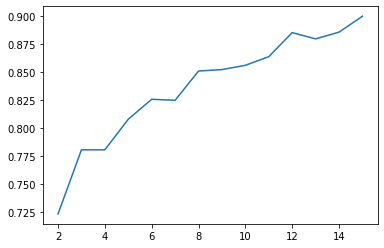

In [682]:
plt.plot(x,y_val)

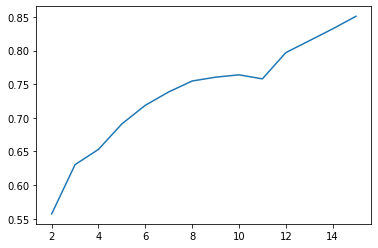

In [683]:
plt.plot(x,y_train)

In [96]:
x=[i for i in range(2,16)]
y_val=[0.6549698948860169,0.6532516360282898,0.690053653717041,0.7286988496780396,0.71748286485672,0.7268608570098877,0.6996452689170838,0.7109903573989869,0.7142420411109924,0.7197230458259583,0.701438021659851,0.7044179081916809,0.7373445868492127,0.7275037169456482]
y_train=[0.5544182,0.65142787,0.6700228,0.69354755,0.7186462,0.7457652,0.7561568,0.76097435,0.7544968,0.7527244,0.7990016,0.8088559,0.8138507,0.8184859]

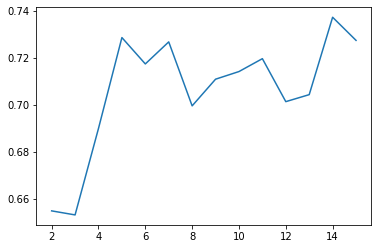

In [97]:
plt.plot(x,y_val)

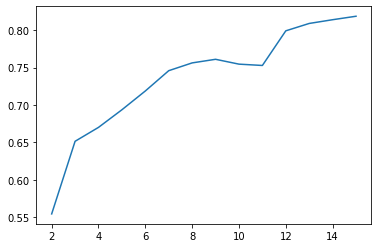

In [98]:
plt.plot(x,y_train)